# Imports

In [1]:
import time
start_time = time.time()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_palette('muted')

from datetime import datetime

from tqdm import tqdm

from sklearn.base import clone

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
DATA_PATH = '../data/equity-post-HCT-survival-predictions/'
RANDOM_STATE = 54321

# Data

In [4]:
sample_df = pd.read_csv(DATA_PATH + 'sample_submission.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')

In [5]:
X = pd.read_pickle(DATA_PATH + 'train_test_split/X_25-12-2024.pkl')
y = pd.read_pickle(DATA_PATH + 'train_test_split/y_25-12-2024.pkl')
efs_time = pd.read_pickle(DATA_PATH + 'train_test_split/efs_time_25-12-2024.pkl')
race_group = pd.read_pickle(DATA_PATH + 'train_test_split/race_group_25-12-2024.pkl')

In [6]:
print(X.shape, y.shape, efs_time.shape, race_group.shape)

(28800, 81) (28800,) (28800,) (28800,)


# Modeling

## Metric

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      3 non-null      int64  
 1   dri_score               3 non-null      object 
 2   psych_disturb           3 non-null      object 
 3   cyto_score              1 non-null      object 
 4   diabetes                3 non-null      object 
 5   hla_match_c_high        2 non-null      float64
 6   hla_high_res_8          2 non-null      float64
 7   tbi_status              3 non-null      object 
 8   arrhythmia              3 non-null      object 
 9   hla_low_res_6           3 non-null      float64
 10  graft_type              3 non-null      object 
 11  vent_hist               3 non-null      object 
 12  renal_issue             3 non-null      object 
 13  pulm_severe             3 non-null      object 
 14  prim_disease_hct        3 non-null      object

In [8]:
import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [9]:
def score_wrapper(y_true, y_pred, efs_time, race_group):
    y_pred_dict = {
        'prediction': {i: pred for i, pred in enumerate(y_pred)}
    }        
    y_pred_dict = pd.DataFrame(y_pred_dict)
    y_pred_dict.insert(0, 'id', range(len(y_pred_dict)))
    
    y_true_dict = {
        'efs': {i: y for i, y in enumerate(y_true.values)},
        'efs_time': {i: t for i, t in enumerate(efs_time.values)},
        'race_group': {i: r for i, r in enumerate(race_group.values)},
    }
    y_true_dict = pd.DataFrame(y_true_dict)
    y_true_dict.insert(0, 'id', range(len(y_true_dict)))
    
    return score(y_true_dict.copy(), y_pred_dict.copy(), 'id')

def cross_validate(model, X, y, cv=10, scale=False):
    cv_scores = []
    
    for i in tqdm(range(cv)):
        test_idxs = list(range(int((len(X)*(i)/cv)), int((len(X)*(i+1)/cv))))
        
        X_train = X.drop(index=test_idxs)
        y_train = y.drop(index=test_idxs)
        
        X_test = X.iloc[test_idxs]
        y_test = y.iloc[test_idxs]
        
        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        model_copy = clone(model)
        
        model_copy.fit(X_train, y_train)
        y_pred = model_copy.predict(X_test)
        
        cv_scores.append(score_wrapper(
            y_test, 
            y_pred, 
            efs_time.iloc[test_idxs], 
            race_group.iloc[test_idxs]
        ))
    
    return np.mean(cv_scores)

## Scikit Learn Model

In [10]:
X = X.dropna()
y = y[X.index].copy()

efs_time = efs_time[X.index].copy()
race_group = race_group[X.index].copy()

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

efs_time.reset_index(drop=True, inplace=True)
race_group.reset_index(drop=True, inplace=True)

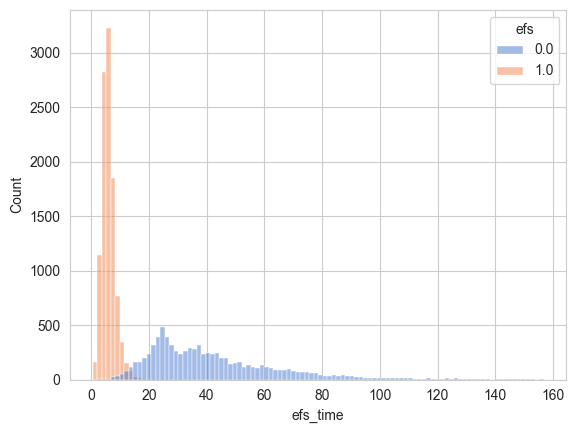

In [11]:
sns.histplot(x=efs_time[y.index], hue=y, bins=100)
plt.show()

### LGBM

In [12]:
model = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)
cv_score = cross_validate(model, X, y, cv=5)

print(f'CV Score: {cv_score:.4f}')

100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

CV Score: 0.6292


### LGBM With efs_time

In [13]:
from sklearn.metrics import mean_absolute_error

In [14]:
def cross_validate_efs_time(model, X, efs_time, cv=10, scale=False):
    cv_scores = []

    for i in tqdm(range(cv)):
        test_idxs = list(range(int((len(X)*(i)/cv)), int((len(X)*(i+1)/cv))))
        
        X_train = X.drop(index=test_idxs)
        y_train = efs_time.drop(index=test_idxs)
        
        X_test = X.iloc[test_idxs]
        y_test = efs_time.iloc[test_idxs]
        
        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        model_copy = clone(model)
        
        model_copy.fit(X_train, y_train)
        y_pred = model_copy.predict(X_test)
        
        cv_scores.append(mean_absolute_error(y_test, y_pred))
    
    return np.mean(cv_scores)

In [15]:
model = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)
cv_score = cross_validate_efs_time(model, X, efs_time, cv=5)

print(f'CV Score: {cv_score:.4f}')

100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

CV Score: 16.2992


### LGBM Combining efs and efs_time

In [16]:
def cross_validate_combined(model_efs, model_efs_time, X, y, efs_time, cv=10, scale=False):
    cv_scores = []
    
    for i in tqdm(range(cv)):
        test_idxs = list(range(int((len(X)*(i)/cv)), int((len(X)*(i+1)/cv))))
        
        X_train = X.drop(index=test_idxs)
        y_train = y.drop(index=test_idxs)
        efs_time_train = efs_time.drop(index=test_idxs)
        
        X_test = X.iloc[test_idxs]
        y_test = y.iloc[test_idxs]
        efs_time_test = efs_time.iloc[test_idxs]
        
        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        model_efs_copy = clone(model_efs)
        model_efs_time_copy = clone(model_efs_time)
        
        model_efs_time_copy.fit(X_train, efs_time_train)
        efs_time_pred = model_efs_time_copy.predict(X_test)
        
        X_train = pd.concat([X_train, efs_time_train], axis=1)
        X_test = pd.concat([X_test, pd.Series(cv_score)], axis=1)
        
        model_efs_copy.fit(X_train, y_train)
        y_pred = model_efs_copy.predict(X_test)
        
        cv_scores.append(score_wrapper(
            y_test, 
            y_pred, 
            efs_time.iloc[test_idxs], 
            race_group.iloc[test_idxs]
        ))
    
    return np.mean(cv_scores)
        

In [17]:
model_efs = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)
model_efs_time = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)

cv_score = cross_validate_combined(model_efs, model_efs_time, X, y, efs_time, cv=5)

print(f'CV Score: {cv_score:.4f}')

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

CV Score: 0.4753


## lifelines

In [21]:
from lifelines import CoxPHFitter

In [187]:
# X_cph = pd.concat([X[[
#     'hla_match_c_high',
#     'hla_high_res_8',
#     # 'hla_low_res_6',
#     # 'hla_high_res_6',
#     # 'hla_high_res_10',
#     # 'hla_match_dqb1_high',
#     # 'hla_nmdp_6',
#     'hla_match_c_low',
#     'hla_match_drb1_low',
#     # 'hla_match_dqb1_low',
#     'year_hct',
#     'hla_match_a_high',
#     # 'donor_age',
#     'hla_match_b_low',
#     'age_at_hct',
#     # 'hla_match_a_low',
#     'hla_match_b_high',
#     'comorbidity_score',
#     'karnofsky_score',
#     # 'hla_low_res_8',
#     # 'hla_match_drb1_high',
#     # 'hla_low_res_10',
#     # 'dri_score',
#     # 'psych_disturb',
#     'cyto_score',
#     'diabetes',
#     # 'tbi_status',
#     # 'arrhythmia',
#     'graft_type',
#     # 'vent_hist',
#     # 'renal_issue',
#     'pulm_severe',
#     # 'cmv_status',
#     'tce_imm_match',
#     # 'rituximab',
#     'prod_type',
#     'cyto_score_detail',
#     'conditioning_intensity',
#     # 'obesity',
#     'mrd_hct',
#     # 'in_vivo_tcd',
#     # 'tce_match',
#     'hepatic_severe',
#     # 'prior_tumor',
#     # 'peptic_ulcer',
#     # 'gvhd_proph',
#     'rheum_issue',
#     'sex_match',
#     # 'hepatic_mild',
#     # 'tce_div_match',
#     'donor_related',
#     # 'melphalan_dose',
#     'cardiac',
#     'pulm_moderate',
#     # 'prim_disease_hct_AI',
#     # 'prim_disease_hct_ALL',
#     # 'prim_disease_hct_AML',
#     # 'prim_disease_hct_CML',
#     # 'prim_disease_hct_HD',
#     'prim_disease_hct_HIS',
#     'prim_disease_hct_IEA',
#     'prim_disease_hct_IIS',
#     # 'prim_disease_hct_IMD',
#     # 'prim_disease_hct_IPA',
#     # 'prim_disease_hct_MDS',
#     # 'prim_disease_hct_MPN',
#     # 'prim_disease_hct_NHL',
#     # 'prim_disease_hct_Other acute leukemia',
#     # 'prim_disease_hct_Other leukemia',
#     # 'prim_disease_hct_PCD',
#     # 'prim_disease_hct_SAA',
#     # 'prim_disease_hct_Solid tumor',
#     # 'ethnicity_Hispanic or Latino',
#     # 'ethnicity_Non-resident of the U.S.',
#     # 'ethnicity_Not Hispanic or Latino',
#     'race_group_American Indian or Alaska Native',
#     # 'race_group_Asian',
#     # 'race_group_Black or African-American',
#     'race_group_More than one race',
#     'race_group_Native Hawaiian or other Pacific Islander',
#     # 'race_group_White',
# ]], y, efs_time], axis=1)

# cph = CoxPHFitter()
# cph.fit(X_cph, duration_col='efs_time', event_col='efs')

# cph.print_summary()

<lifelines.CoxPHFitter: fitted with 19280 total observations, 8668 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 19280
number of events observed = 10612
   partial log-likelihood = -99565.22
         time fit was run = 2025-01-06 00:23:25 UTC

---
                                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                             
hla_match_c_high                                     -0.20      0.82      0.06           -0.32           -0.08                0.72                0.93
hla_high_res_8                                        0.22      1.24      0.04            0.14            0.30                1.15                1.35
hla_match_c_low                                      -0.18      0.83      0.04           -0.27           -0.10                0.77                0.91
hla_match_drb1_low                                    0.10      1.10      0.04            0.01            0.18                1.01                1.20
year_hct                                             -0.03      0.97      0.00           -0.04           -0.03                0.96                0.97
hla_match_a_high                                     -0.45      0.64      0.06           -0.56           -0.34                0.57                0.71
hla_match_b_low                                       0.14      1.15      0.05            0.05            0.23                1.05                1.26
age_at_hct                                            0.01      1.01      0.00            0.00            0.01                1.00                1.01
hla_match_b_high                                     -0.30      0.74      0.06           -0.42           -0.19                0.66                0.83
comorbidity_score                                     0.08      1.09      0.00            0.07            0.09                1.08                1.10
karnofsky_score                                      -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
cyto_score                                            0.04      1.04      0.00            0.03            0.05                1.03                1.05
diabetes                                              0.04      1.04      0.01            0.02            0.06                1.02                1.07
graft_type                                            0.14      1.15      0.05            0.05            0.23                1.05                1.26
pulm_severe                                           0.25      1.29      0.04            0.18            0.33                1.20                1.39
tce_imm_match                                        -0.02      0.98      0.00           -0.03           -0.01                0.97                0.99
prod_type                                             0.16      1.17      0.05            0.07            0.25                1.07                1.28
cyto_score_detail                                    -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
conditioning_intensity                                0.09      1.09      0.01            0.07            0.11                1.07                1.12
mrd_hct                                              -0.12      0.89      0.03           -0.17           -0.07                0.84                0.94
hepatic_severe                                       -0.14      0.87      0.03           -0.21           -0.08                0.81                0.92
rheum_issue                                          -0.17      0.84      0.04           -0.25           -0.09                0.78                0.91
sex_matc

In [ ]:
X_cph = pd.concat([X[[
    'hla_match_c_high',
    'hla_high_res_8',
    'hla_low_res_6',
    # 'hla_high_res_6',
    'hla_high_res_10',
    # 'hla_match_dqb1_high',
    'hla_nmdp_6',
    'hla_match_c_low',
    'hla_match_drb1_low',
    'hla_match_dqb1_low',
    'year_hct',
    'hla_match_a_high',
    'donor_age',
    'hla_match_b_low',
    'age_at_hct',
    # 'hla_match_a_low',
    'hla_match_b_high',
    'comorbidity_score',
    'karnofsky_score',
    # 'hla_low_res_8',
    # 'hla_match_drb1_high',
    # 'hla_low_res_10',
    'dri_score',
    'psych_disturb',
    'cyto_score',
    'diabetes',
    'tbi_status',
    'arrhythmia',
    'graft_type',
    'vent_hist',
    'renal_issue',
    'pulm_severe',
    'cmv_status',
    'tce_imm_match',
    'rituximab',
    'prod_type',
    'cyto_score_detail',
    'conditioning_intensity',
    'obesity',
    'mrd_hct',
    'in_vivo_tcd',
    'tce_match',
    'hepatic_severe',
    'prior_tumor',
    'peptic_ulcer',
    'gvhd_proph',
    'rheum_issue',
    'sex_match',
    'hepatic_mild',
    'tce_div_match',
    'donor_related',
    'melphalan_dose',
    'cardiac',
    'pulm_moderate',
    'prim_disease_hct_AI',
    'prim_disease_hct_ALL',
    'prim_disease_hct_AML',
    'prim_disease_hct_CML',
    'prim_disease_hct_HD',
    'prim_disease_hct_HIS',
    'prim_disease_hct_IEA',
    'prim_disease_hct_IIS',
    'prim_disease_hct_IMD',
    'prim_disease_hct_IPA',
    'prim_disease_hct_MDS',
    'prim_disease_hct_MPN',
    'prim_disease_hct_NHL',
    'prim_disease_hct_Other acute leukemia',
    'prim_disease_hct_Other leukemia',
    'prim_disease_hct_PCD',
    'prim_disease_hct_SAA',
    # 'prim_disease_hct_Solid tumor',
    'ethnicity_Hispanic or Latino',
    'ethnicity_Non-resident of the U.S.',
    'ethnicity_Not Hispanic or Latino',
    'race_group_American Indian or Alaska Native',
    'race_group_Asian',
    'race_group_Black or African-American',
    'race_group_More than one race',
    'race_group_Native Hawaiian or other Pacific Islander',
    # 'race_group_White',
]], y, efs_time], axis=1)

cph = CoxPHFitter()
cph.fit(X_cph, duration_col='efs_time', event_col='efs')

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 19280 total observations, 8668 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 19280
number of events observed = 10612
   partial log-likelihood = -99487.16
         time fit was run = 2025-01-06 00:17:11 UTC

---
                                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                             
hla_match_c_high                                     -0.21      0.81      0.06           -0.34           -0.09                0.71                0.92
hla_high_res_8                                        0.26      1.30      0.06            0.15            0.38                1.16                1.46
hla_low_res_6                                        -0.09      0.91      0.04           -0.17           -0.02                0.84                0.98
hla_high_res_10                                      -0.02      0.98      0.03           -0.09            0.04                0.91                1.04
hla_nmdp_6                                           -0.02      0.98      0.02           -0.06            0.02                0.94                1.02
hla_match_c_low                                      -0.16      0.86      0.04           -0.24           -0.07                0.78                0.93
hla_match_drb1_low                                    0.23      1.26      0.06            0.11            0.35                1.11                1.42
hla_match_dqb1_low                                    0.00      1.00      0.04           -0.07            0.07                0.94                1.08
year_hct                                             -0.03      0.97      0.00           -0.04           -0.03                0.96                0.97
hla_match_a_high                                     -0.39      0.67      0.06           -0.51           -0.28                0.60                0.76
donor_age                                             0.00      1.00      0.00            0.00            0.00                1.00                1.00
hla_match_b_low                                       0.26      1.29      0.06            0.13            0.38                1.14                1.46
age_at_hct                                            0.00      1.00      0.00            0.00            0.01                1.00                1.01
hla_match_b_high                                     -0.31      0.74      0.06           -0.43           -0.19                0.65                0.83
comorbidity_score                                     0.08      1.08      0.01            0.07            0.09                1.07                1.09
karnofsky_score                                      -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
dri_score                                             0.01      1.01      0.00            0.00            0.02                1.00                1.02
psych_disturb                                         0.01      1.01      0.01           -0.02            0.04                0.98                1.04
cyto_score                                            0.03      1.03      0.01            0.02            0.04                1.02                1.04
diabetes                                              0.04      1.04      0.01            0.02            0.07                1.02                1.07
tbi_status                                            0.01      1.01      0.00            0.00            0.02                1.00                1.02
arrhythmia                                            0.00      1.00      0.02           -0.03            0.04                0.97                1.04
graft_ty

In [19]:
end_time = time.time()
print(f'Execution time: {end_time - start_time:.2f} seconds')

Execution time: 8.07 seconds
